## 0) Import necessary stuff

In [1]:
import sys
sys.path.append('..')

from pecebl.designer import designer as pg
from pecebl.psf_import.casino import Casino3 as cs3
from pecebl.sem import supra40 as beamer
from pecebl.utils import *

from pecebl.ebl_kernels.kernels_pycuda import PsfDoseGenerator as psfdosegen
from pecebl.fft_ops import fft_ops as fft

C:\Users\Loon\Anaconda3\envs\pecebl_dev\lib\site-packages\skcuda\cublas.py:284: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


## I) Create a pattern : photonic crystal

### I-1) Draw the pattern we want to expose.
For this demo we use the photonic crystal (`example1`) centered at `(0,0)`, hole radius `48 nm`, pitch `170 nm` and stepsize `4 nm`

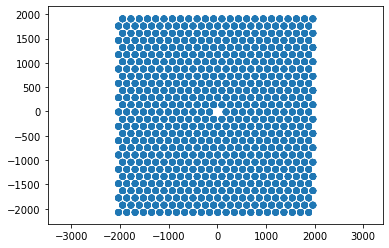

275781 dots in this pattern.


In [2]:
#example1
ss=4;final_pattern=pg.example1(a=170, r=48, ss=ss)
plt.plot(final_pattern[:,0], final_pattern[:,1], 'o', ms=1)
plt.axis('equal');plt.show()
print(f'{final_pattern.shape[0]} dots in this pattern.')

### I-2) Define data size

We use the writefiled size a bit bigger than the pattern size, let's use 5000.0 nm.

If your NVIDIA GPU permits, you can give a large matrix size. 2048 pixels should work on most of NVIDIA GPU nowaday.

In [3]:
# matrix size and writefield size:
mat_size, wf_nm = 2048, 5000.0

# pixel size
pixel_centered=True #True: (0,0) is in the [NP/2,NP/2] location.
pixel_size=np.float32(wf_nm/mat_size) if pixel_centered else np.float32(wf_nm/(mat_size-1))
print('pixel size: ', pixel_size)


pixel size:  2.4414062


### I-3) Building the dose distribution:
#### I-3-1) Cut pattern into grid of blocks

In [4]:
# let's find block and grid dimensions
from sympy.ntheory import primefactors, factorint

factorint(final_pattern.shape[0]), primefactors(final_pattern.shape[0])

({3: 1, 11: 1, 61: 1, 137: 1}, [3, 11, 61, 137])

#### I-3-2) Build the dose distribution

*dose_dis* is the initial dose distribution for this demo pattern. By default, dose factor = 1 at each dot of the pattern.

In [5]:
#instance of psf_dose generator
psf_dose_gen = psfdosegen(mat_size, wf_nm, pixel_size)
psf_dose_gen.setgpu()

dose_dis = psf_dose_gen.dosegen_gpu(final_pattern, block=(61,11,1), grid=(137,3,1))

Dose calculated on GPU in 0.073544 s
overlap = -661.0. Negative value = lost dose.


## II) Use Casino3 software

In this first demo I use a PSF (Point Spread Function) from Casino3 to expose our demo pattern.

The Casino3 software can be downloaded here http://www.gel.usherbrooke.ca/casino/. You have to register to download

The demo sample is a 300nm ZEP520A resist layer on a silicon substrate. For this example I use 1e7 electrons with 30kV of accelerate voltage and the options are:

    no generate secondary electrons,
    1nm beam diameter,
    100 mrad beam semi-angle
    1.65 gaussian beam distribution.
    cartesian distribution for data
    ...

more parameters are in the sample file _ZEP520A300_Si.sim_ given with this demo.

The PSF is saved in _zep520_1e7_30kV_100mrad_1pt_ file. This file will be used in this example.

## III) Building the PSF kernel
We will get at the end of this section a 2D matrix kernel with the psf at the center. Here are the steps to do:

1. Decide the hardware parameters you want to use: the beam energy, the beam current. And the physical properties of your sample.
2. Import the interaction between the electron beam and our sample from the above software [Casino3](http://www.gel.usherbrooke.ca/casino/). We call it the *psf function*.
3. Map the *psf function* to a 2D matrix of size equals to the writefield you want to simulate. We call it the *PSF kernel*.

### III-1) Setup the electron beamer
We use a *Zeiss Supra40* SEM with `30 kV` and the `7.5 µm` aperture

In [6]:
meb = beamer.Supra40(30) #we use a sem Zeiss Supra40 at 30kV
meb.change_aperture(7.5) #use the 7.5 µm aperture
meb.info()

SEM info:
current aperture size: 7.5 µm
current voltage: 30 kV
beam current: 28 pA



### III-2) Import simulated data from Casino3

Monte-Carlo data: import psf file _zep520_1e7_30kV_100mrad_1pt_ from Casino3

In [7]:
sim=cs3('data/zep520_1e7_30kV_100mrad_1pt') #data from Casino3 software

The number of electron paths simulated in Casino3 was `1e7`. The beam writer Raith Elphy Plus has `6 MHz` of electronic speed.
`i_y` for locating at the peak of the psf and `i_z` for placing at the middle depth of the ebeam resist. In this example, I use **Casino3** in a grid size of `(x=8000, y=0.6, z=310)` in *nm* divided by `(nx=8000, ny=6, nz=6)` dots, hence `i_y=3` and `i_z=3`. Now we can get the `psf_fct`:

In [8]:
psf_fct=get_psf_fct(1e7, sim, 6, meb.beam_current, i_y=3, i_z=3)

# print the min, max  and mean values:
log_message = f'min value = {np.min(psf_fct[:,1])}; mean value = {np.mean(psf_fct[:,1])}; max value = {np.max(psf_fct[:,1])}.'
print(log_message)

min value = 0.0; mean value = 0.0004177630643507655; max value = 0.19654753413827822.


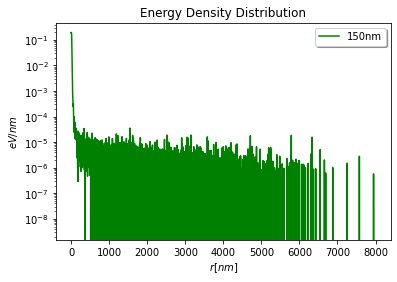

In [9]:
#let's see what look-like the pre-PSF at 150 nm depth of the ebeam resist:
plt.semilogy(psf_fct[:,0],psf_fct[:,1],'g-',label='150nm')
plt.title('Energy Density Distribution');
plt.xlabel('$r[nm]$')
plt.ylabel('$eV/nm$')
plt.legend(loc='upper right', shadow=True)
plt.show()

### III-3) Building the PSF kernel:

z_PSF created on GPU in 0.089672 s
min value = 0.0; max value = 0.19314753448505648; sum value = 40.45887546800713.


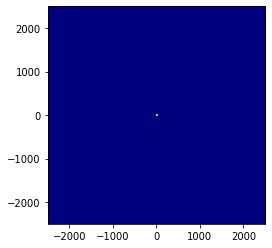

In [10]:
# build the psf kernel, we cut the matrix size in blocks and grids
z_psf = psf_dose_gen.psfgen_gpu(psf_fct, location=pg.dot(0,0)[0],block=(32,16,1), grid=(128,64,1))

#plot PSF:
plt.imshow(z_psf,origin='lower', extent=[-wf_nm/2, wf_nm/2, -wf_nm/2, wf_nm/2],interpolation="nearest", cmap=plt.cm.jet)
plt.show()

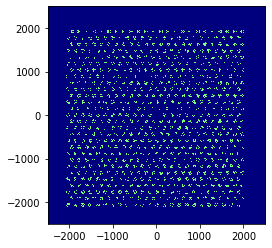

In [11]:
# Let's exposure at 30 µC/cm²:
dose_dis *= dtfactor(30,ss,meb.beam_current) #dtfactor = dwelltime factor

plt.imshow(dose_dis,origin='lower', extent=[-wf_nm/2, wf_nm/2, -wf_nm/2, wf_nm/2],interpolation="nearest", cmap=plt.cm.jet)
plt.show()

## IV) Simulation of ebeam exposure
### IV-1) Padding the PSF
PSF kernel need to be expanded to image (expo) size and padded according to **Victor Podlozhnyuk**'s white paper *FFT-based 2D  convolution*: PSF kernel and resulting exposure data have the same size

In [12]:
#padded psf prior to fft transform:
ppsf=np.empty((mat_size,mat_size),np.float64)
ppsf[:mat_size//2-1,mat_size//2+1:]=z_psf[mat_size//2+1:,:mat_size//2-1]
ppsf[:mat_size//2-1,:mat_size//2+1]=z_psf[mat_size//2+1:,mat_size//2-1:]
ppsf[mat_size//2-1:,:mat_size//2+1]=z_psf[:mat_size//2+1,mat_size//2-1:]
ppsf[mat_size//2-1:,mat_size//2+1:]=z_psf[:mat_size//2+1,:mat_size//2-1]

del z_psf

### IV-2) Exposure using FFT convolution

Convolution by FFT principe:
 - apply direct FFT to the convolution kernel (padded)
 - apply direct FFT to the input data array (or image)
 - perform the point-wise multiplication of the two preceding results
 - apply inverse FFT to the result of the multiplication
 
We have the PSF and the dose distribution, we can do a FFT convolution to expose our pattern: 

GPU : FFT(psf) = psf in-place fft..
GPU : FFT(dose_pc) = dose_dis in-place fft..
GPU : point-wise multiplication of two matrices...
GPU : inverse FFT to get exposure energy distribution...
convolution done on GPU in 11.445182 s
71.5 % of device memory is free.
74.6 % of device memory is free.
0.4837629689810848 -7.340227779537144e-15 12.80082096752389 8.406951520472189e-15


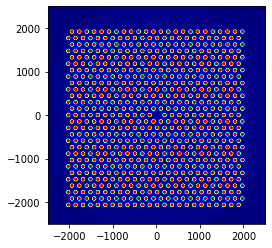

In [13]:
z = fft.fft_exposure(ppsf, dose_dis)

print(np.min(z.real),np.min(z.imag),np.max(z.real),np.max(z.imag))

plt.imshow(z.real,origin='lower', extent=[-wf_nm/2, wf_nm/2, -wf_nm/2, wf_nm/2],interpolation="nearest", cmap=plt.cm.jet)
plt.show()

## V) Develop
- a clearing dose 12 eV/nm with step size 4 nm give resist threshold = 3 eV

In [14]:
#z *= 1 #dose increase x times
np.min(z.real),np.mean(z.real), np.max(z.real),np.min(z.imag),np.max(z.imag)

(0.4837629689810848,
 2.7296723602519233,
 12.80082096752389,
 -7.340227779537144e-15,
 8.406951520472189e-15)

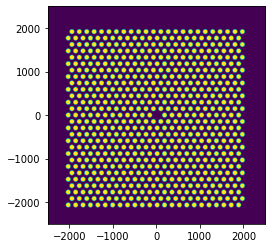

In [15]:
th_resist=3 #clearing dose = 3 eV
z_dev = (z.real> th_resist) * z.real

z_dev[z_dev > 0] = 1

plt.imshow(z_dev,origin='lower', extent=[-wf_nm/2, wf_nm/2, -wf_nm/2, wf_nm/2]);plt.show()
plt.show()

In [16]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.linspace(-wf_nm/2, wf_nm/2, mat_size)
Y = np.linspace(-wf_nm/2, wf_nm/2, mat_size)
X, Y = np.meshgrid(X, Y)
Z = z.real

cmap=plt.get_cmap('jet')
minZ=np.min(Z);maxZ=np.max(Z)
rgba_img=cmap((Z-minZ)/(maxZ-minZ))

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(minZ, maxZ)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

ValueError: Unknown projection '3d'

<Figure size 432x288 with 0 Axes>